# MQ04. 폐렴진단

### 개요
1. 의료 영상의 기초 상식에 대해 알아본다.
    - 의료영상 자세 분류
    - X-RAY 특성

2. 실제로 의료 영상 데이터를 처리하는 실습 진행

3. 폐렴 진단기 성능 개선
- Batch size, Epoch 등의 파라미터 변경
- 이미지 augmentation 진행(좌우 반전만)
- ResNet-18 모델을 구현하여 학습 진행

## ★ 실습
### 1. Set-up

In [2]:
# 라이브러리 호출
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 앞으로 쓸 변수 생성 

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### 2. 데이터 가져오기


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와 보자
- rain과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
# 정상 이미지와 폐렴 이미지 구분(파일 경로에 NORMAL과 PNEUMONIA 여부로 구분하자!)
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
# tf.data 인스턴스 만들기 -> 미니배치로 작업하기 위함.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 라벨 데이터를 만들어 주는 함수 만들기
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.


In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 및 라벨 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# test 데이터셋도 동일하게 진행
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

- shuffle()을 사용하면 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3. 데이터 시각화
- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다.
- 추출된 배치를 image와 label 데이터 셋으로 나눕니다.
- show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

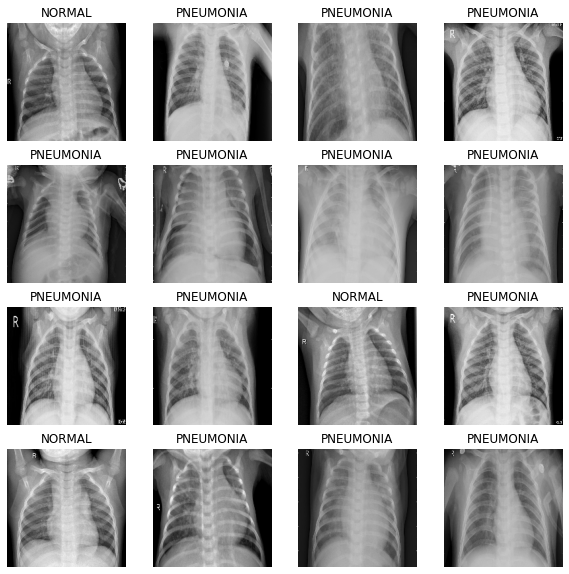

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. CNN 모델링

In [15]:
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
# 모델 생성
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 imbalance 처리

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # 'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 # 'Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 6. 모델 훈련
-  모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
- optimizer로 'adam'을 사용
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [19]:
with tf.device('/GPU:0'): # 이미지 훈련에 GPU 사용
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 199ms/step - loss: 0.3962 - accuracy: 0.7948 - precision: 0.9539 - recall: 0.7606 - val_loss: 0.6166 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2158 - accuracy: 0.9140 - precision: 0.9741 - recall: 0.9085 - val_loss: 1.3603 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 199ms/step - loss: 0.2018 - accuracy: 0.9282 - precision: 0.9769 - recall: 0.9253 - val_loss: 0.1225 - val_accuracy: 0.9567 - val_precision: 0.9738 - val_recall: 0.9675
Epoch 4/10
261/261 [==============================] - 52s 199ms/step - loss: 0.1796 - accuracy: 0.9291 - precision: 0.9798 - recall: 0.9236 - val_loss: 0.2507 - val_accuracy: 0.9058 - val_precision: 0.9985 - val_recall: 0.8735
Epoch 5/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1559 - accura

### 7. 결과 확인
- 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

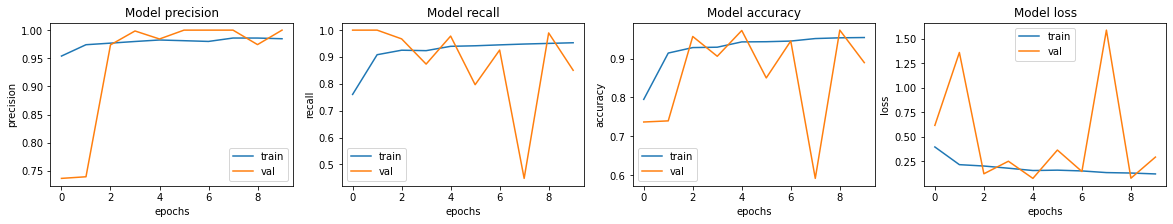

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.3861 - accuracy: 0.8622 - precision: 0.8535 - recall: 0.9410
Loss: 0.38608232140541077,
Accuracy: 0.8621794581413269,
Precision: 0.8534883856773376,
Recall: 0.9410256147384644


## ★ 프로젝트 : 폐렴 진단기 성능개선

### Step 1. 실험환경 Set-up
- Batch size: 16 → 20
- Epoch: 10 → 15

In [33]:
BATCH_SIZE = 20
EPOCHS = 12

### Step 2. 데이터 준비하기
- 의료 영상 이미지의 특성상 데이터의 양이 충분하지 않으므로 augmentation 기법을 사용하여 데이터 셋을 부풀려본다.
- X-RAY 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈가 오히려 방해를 줄 수도 있기 때문에 좌우 반전만 도입.

In [24]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds
# 배치 사이즈가 변경됨에 따라 train_ds를 초기화한 후 prepare_for_training 진행!!!
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화

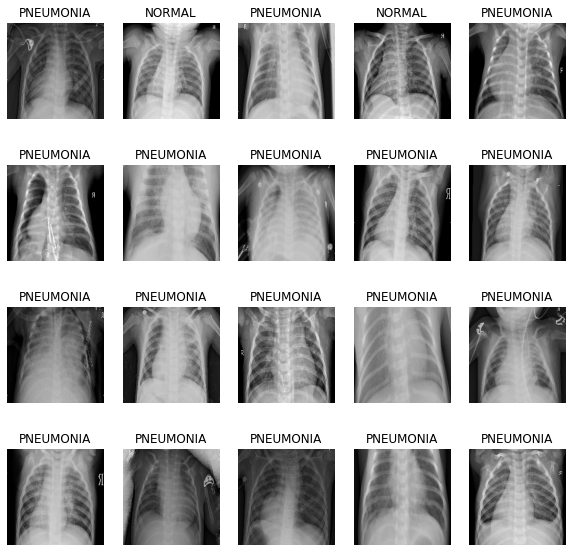

In [26]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. ResNet-18 구현

In [49]:
# ResNet-18 아키텍처 정의

# Residual block 구성하기
def resnet_block(inputs, filters, strides=1, activation=tf.nn.relu):
    # 첫 번째 컨볼루션 레이어
    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation(x)
    
    # 두 번째 컨볼루션 레이어
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # 스킵 연결(skip connection)
    if strides > 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs
        
    x = tf.keras.layers.add([x, shortcut])
    x = activation(x)
    
    return x

def resnet18(input_shape=(180, 180, 3), num_classes=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # 첫 번째 레이어
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # ResNet-18 아키텍처 중간 부분
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)
    
    # 마지막 레이어
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    
    # 모델 생성
    model = tf.keras.models.Model(inputs, x)
    
    return model


### Step 5. 데이터 imbalance 처리

In [28]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # 'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 # 'Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### Step 6. 모델 훈련
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" 그대로 적용
- optimizer = 'sgd' / learning_rate=0.015 로 변경
- 여기선 ResNet-18 모델을 사용하므로 실습에서 썼던 'model = build_model()'대신 'model = resnet18()'을 넣어준다.

In [57]:
# ResNet-18 모델 생성

with tf.device('/GPU:0'): # 이미지 훈련에 GPU 사용
    model = resnet18() 
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.015),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [58]:
# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/12
209/209 [==============================] - 57s 234ms/step - loss: 0.2440 - accuracy: 0.8955 - precision: 0.9642 - recall: 0.8927 - val_loss: 2.5527 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/12
209/209 [==============================] - 48s 229ms/step - loss: 0.1531 - accuracy: 0.9385 - precision: 0.9779 - recall: 0.9386 - val_loss: 4.0299 - val_accuracy: 0.4029 - val_precision: 1.0000 - val_recall: 0.1840
Epoch 3/12
209/209 [==============================] - 48s 232ms/step - loss: 0.1229 - accuracy: 0.9517 - precision: 0.9847 - recall: 0.9498 - val_loss: 2.1799 - val_accuracy: 0.4875 - val_precision: 0.9792 - val_recall: 0.3080
Epoch 4/12
209/209 [==============================] - 50s 242ms/step - loss: 0.0982 - accuracy: 0.9610 - precision: 0.9881 - recall: 0.9592 - val_loss: 0.8797 - val_accuracy: 0.6308 - val_precision: 0.9974 - val_recall: 0.4980
Epoch 5/12
209/209 [==============================] - 51s 247ms/step - loss: 0.0823 - accura

### Step 7. 결과 확인과 시각화
- Optimizer를 SGD로 하니 그래프 결과가 들쑥날쑥하여 다시 Adam으로 바꾸고 학습률은 0.012로 진행해보기로 하였다.

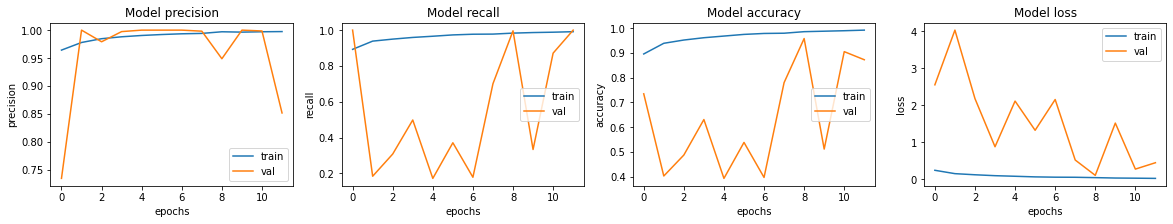

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [60]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 4s 134ms/step - loss: 2.8183 - accuracy: 0.6474 - precision: 0.6393 - recall: 1.0000
Loss: 2.8182835578918457,
Accuracy: 0.6474359035491943,
Precision: 0.6393442749977112,
Recall: 1.0


## 회고

- 평소 관심있던 분야(의학)를 주제로 모델 실습을 진행할 수 있어 더욱 흥미로웠다.
- 성능 개선 단계에서 배치 사이즈가 변경됨에 따라 train_ds를 초기화한 후 다시 prepare_for_training 진행!!
    : 초기화를 하지 않고 모델 fit을 하려니 train_ds의 shape이 한 차원 더 증가됨에 따라 에러가 발생하였다.
- ResNet-18 모델을 사용하므로 실습에서 썼던 'model = build_model()' 대신 model = resnet18()을 넣어준다.
    : 이 부분도 놓쳐서 모델 학습 시, 실습때 썼던 모델을 바탕으로 진행되었다.
- 마지막 테스트 데이터로 모델 평가 중 recall 값이 1로 고정된 채로 진행되었는데 분명 무언가 실수를 하였다. 그런데 원인을 파악하지 못 한 채로 제출하게 되어 아쉬움이 크다...ㅠㅠ 